In [1]:
import sys, os
sys.path.append(os.path.abspath("..")) 

from src.preprocessing import Preprocessor
from src.models import LogisticModel, KNNModel, SVMModel, RFModel, get_default_models
from src.models import get_default_models
from src.evaluator import Evaluator

In [2]:
prep1 = Preprocessor("/Users/wendy/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 2/MATE50001/Computing/Coursework/dataset_2 (1).csv")
X_train1, X_test1, y_train1, y_test1 = prep1.preprocess()

In [3]:
models = get_default_models()
ev = Evaluator(class_names=["non-conductive", "conductive"])

from sklearn.metrics import accuracy_score

for name, model in models.items():
    model.fit(X_train1, y_train1)
    y_pred = model.predict(X_test1)
    acc = accuracy_score(y_test1, y_pred)
    print(name, "test accuracy:", acc)

logistic test accuracy: 0.9594594594594594
knn test accuracy: 0.9324324324324325
svm_rbf test accuracy: 0.9594594594594594
random_forest test accuracy: 1.0


=== logistic ===
{'accuracy': 0.9594594594594594, 'precision': 1.0, 'recall': 0.918918918918919, 'f1': 0.9577464788732394}


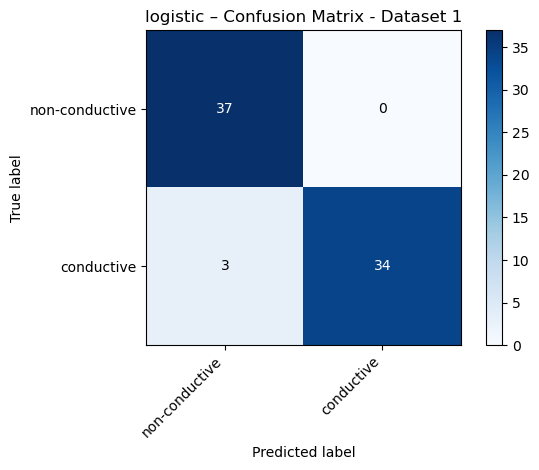

=== knn ===
{'accuracy': 0.9324324324324325, 'precision': 1.0, 'recall': 0.8648648648648649, 'f1': 0.927536231884058}


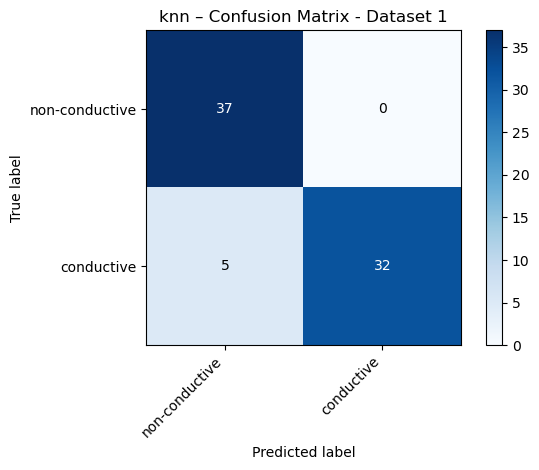

=== svm_rbf ===
{'accuracy': 0.9594594594594594, 'precision': 1.0, 'recall': 0.918918918918919, 'f1': 0.9577464788732394}


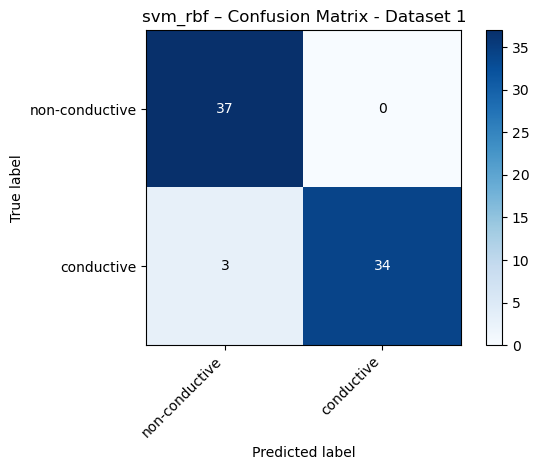

=== random_forest ===
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


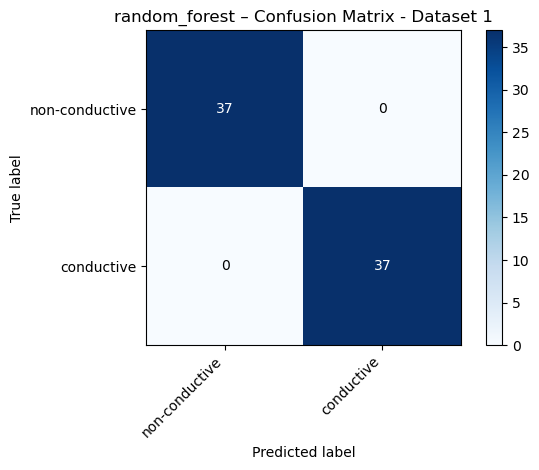

In [13]:
os.makedirs("plots", exist_ok=True)
os.makedirs("metrics", exist_ok=True)

ev = Evaluator(class_names=["non-conductive", "conductive"])

models = get_default_models()
results = {}

for name, model in models.items():
    model.fit(X_train1, y_train1)
    y_pred = model.predict(X_test1)

    metrics = ev.compute_metrics(
        y_test1,
        y_pred,
        average="binary",
        pos_label=1
    )
    results[name] = metrics

    print(f"=== {name} ===")
    print(metrics)

    ev.plot_confusion_matrix(
        y_test1,
        y_pred,
        title=f"{name} – Confusion Matrix - Dataset 2",
        save_path=f"plots/dataset2_confusion_{name}.png",
        save_metrics_path=f"metrics/dataset2_confusion_{name}.csv",
    )